# IBM Data Science Capstone Project
# Hierarchy of Toy Stores in LA

**by**
**Joshua Pascascio**

## Introduction

This project is designed to provide new categories and ways to group toy stores in Los Angeles as to help provide a more detailed, personal insights for both toy vendors and toy buyers.

### Stakeholders / Audience

The audience for this report includes both toy store vendors, meaning companies who have physical stores that sell, sometimes exclusively, some sort of toy products as well as the customers. The customers that are the primary focus are toy collectors especially those that collect specific products like FunKo Pops or anime figurines from a franchise. For vendors, these insights, especially when it comes to what categories and related category of store they belong to, can give guidance on to their marketing and what products they should focus on for promotion. For customer it can provide easier ways to search and navigate stores based on their interest.

## Data 

The primary data source will be data retrieved from the FourSquare API on venues and categories. To get a better understanding of the geography and neighborhoods of Los Angeles we will also be using data fetched from the <a href="http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data#SOCR_Data_-_Los_Angeles_City_Neighborhoods_Data" target="_blank" title="Neighborhood data from UCLA Website">UCLA website.</a> 


### Foursquare API Endpoints

The overall method of retrieving our data for clustering is to

1. Query for all `venues` in the city of **Los Angeles** with a radius of *500 miles* that belong to the category of `Toy Store`, sorted by ***popularity***.
2. For *every venue* do another query by its **VENUE_ID** to retrieve further details.
3. Query for all `categories` in the Foursquare system to find the category of `Toy / Game Store` and see its **CATEGORY_ID** and where it relates in the hierarchy of greater categories in the API database.


### UCLA Data

1. Extract the tabular data from the HTML website and scrape the neighborhood data for each neighborhood's *corresponding latitude and longitude*.

## Data Collection

### Import all the necessary libraries

Libraries include:

* Geopy
* Matplotlib
* numpy
* folium
* pandas

In [90]:
!conda install -c conda-forge pandas kmodes scipy python-igraph folium=0.5.0

Solving environment: done

# All requested packages already installed.



In [91]:
!pip install gower

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [7]:
## Import into python notebook environment
from bs4 import BeautifulSoup

from kmodes.kmodes import KModes

import requests
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Establish and Import Foursquare Credentials

In [10]:
CLIENT_ID = 'YOUR_CLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_CLIENT_SECRET' # your Foursquare Secret
VERSION = 'YOUR_VERSION' # Foursquare API version
LIMIT = 55 # A default Foursquare API limit value
LOCATION='Los Angeles,CA'
RADIUS=1000
CATEGORY_NAME = 'Toy / Game Store'

### Establish Foursquare URL Templates
In total we will use **3** API endpoints from Foursquare. 

1. Endpoint `venues/categories` to find the `categoryId` and related categories of category with *name*, **Toy / Game Store**
2. Endpoint `venues/search` to search for venues in the **Los Angeles** area that belong to the **Toy / Game Store** *category*
3. Endpoint `venues/{VENUE_ID}` to retrieve a venue's *individual details* and retrieve features such as its **likes, listings, and related categories**

In [11]:
category_api_url = 'http://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'
venue_search_url = 'http://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near={}&sortByPopularity=1&radius={}&categoryId={}&limit={}'
venue_id_api_url = 'http://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'

We use a ***recursive search*** algorithm to search the **API Response** for the category with name `Toy / Game Store` and retrieve its *related* categories. From there a mapping by `category name` can be created where the values include the **id, its children's names, and those childrens' names accordingly**

In [12]:
def search_categories(name,categories):
    for c in categories:
        if c['name'] == name:
            return c['id'],categories
        elif 'categories' in c and len(c['categories']) > 0:
            return search_categories(name,c['categories'])
    return ('',[])
    


### Search and retrieve a Foursquare Category Id by a name
### by searching the Categories api in FourSquare
def find_foursquare_category(url,client_id,client_secret,version,name):
    cat_id     = ''
    data_map = {}
    final_categories = []
    api_url  = url.format(client_id,client_secret,version)
    json     = requests.get(api_url).json()
    if 'response' in json and 'categories' in json['response']:
        if len(json['response']['categories']) > 0:
            print(json['response']['categories'][8])
            for v in json['response']['categories']:
                if v['name'] == name:
                    cat_id = v['id']
                elif 'categories' in v and len(v['categories']) > 0:
                    for c in v['categories']:
                        if c['name'] == name:
                            cat_id = c['id']
                            final_categories = v['categories']
                            return c['id'],v['categories']
                        elif 'categories' in c and len(c['categories']) > 0:
                            for cat in c['categories']:
                                if cat['name'] == name:
                                    return cat['id'],c['categories']
                
    return cat_id,data_map

def create_foursquare_df(url,client_id,client_secret,version):
    mapping = {}
    api_url  = url.format(client_id,client_secret,version)
    json     = requests.get(api_url).json()
    if 'response' in json and 'categories' in json['response']:
        if len(json['response']['categories']) > 0:
            for v in json['response']['categories']:
                mapping[v['name']] = {'id':v['id'],'grandparent':None,'parent':None,'children':[]}
                if 'categories' in v:
                    for c in v['categories']:
                        mapping[v['name']]['children'].append(c['name'])
                        mapping[c['name']] = {'id':c['id'],'parent':v['name'],'grandparent':None,'children':[]}
                        if 'categories' in c:
                            for cat in c['categories']:
                                mapping[c['name']]['children'].append(cat['name'])
                                mapping[cat['name']] = {'id':cat['id'],'parent':c['name'],'grandparent':v['name'],'children':[]}
    return mapping
    
def create_category_df(mapping):
    data = {
        'id':[],
        'name':[],
        'parent':[],
        'grandparent':[],
        'children':[]
    }
    for key,value in mapping.items():
        data['id'].append(value['id'])
        data['name'].append(key)
        data['parent'].append(value['parent'])
        data['grandparent'].append(value['grandparent'])
        data['children'].append(value['children'])
    df = pd.DataFrame(data)
    return df

mapping = create_foursquare_df(category_api_url,CLIENT_ID,CLIENT_SECRET,VERSION)
category_item     = mapping[CATEGORY_NAME]
cat_id            = category_item['id']
cat_id
# category_df       = create_category_df(mapping)
# category_df.head(25)

'4bf58dd8d48988d1f3941735'

Now we have a `dict` object in the variable `mapping` where we can search and retrieve by **category name**. 
From there, we can search by the category name `Toy / Game Store` as the **key** and once we retrieve the value, we 
can fetch the `id` key to have the **category id**

The category id for `Toy / Game Store` is `'4bf58dd8d48988d1f3941735'`

To better visualize the related categories and the overall ***parent-child*** structure
of categories and their children categories can be visualized again with a `DataFrame` 
table by calling the `create_category_df` **function** on the `mapping` **variable**.

In [13]:
category_df = create_category_df(mapping)
category_df.head(30)

,id,name,parent,grandparent,children
0,4d4b7104d754a06370d81259,Arts & Entertainment,None,None,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,56aa371be4b08b9a8d5734db,Amphitheater,Arts & Entertainment,None,[]
2,4fceea171983d5d06c3e9823,Aquarium,Arts & Entertainment,None,[]
3,4bf58dd8d48988d1e1931735,Arcade,Arts & Entertainment,None,[]
4,4bf58dd8d48988d1e2931735,Art Gallery,Arts & Entertainment,None,[]
5,4bf58dd8d48988d1e4931735,Bowling Alley,Arts & Entertainment,None,[]
6,4bf58dd8d48988d17c941735,Casino,Arts & Entertainment,None,[]
7,52e81612bcbc57f1066b79e7,Circus,Arts & Entertainment,None,[]
8,4bf58dd8d48988d18e941735,Comedy Club,Arts & Entertainment,None,[]
9,5032792091d4c4b30a586d5c,Concert Hall,Arts & Entertainment,None,[]


To get a better understanding of the distribution of categories we will draw several **histograms** 
of the category data based on their ***shared parent***. 

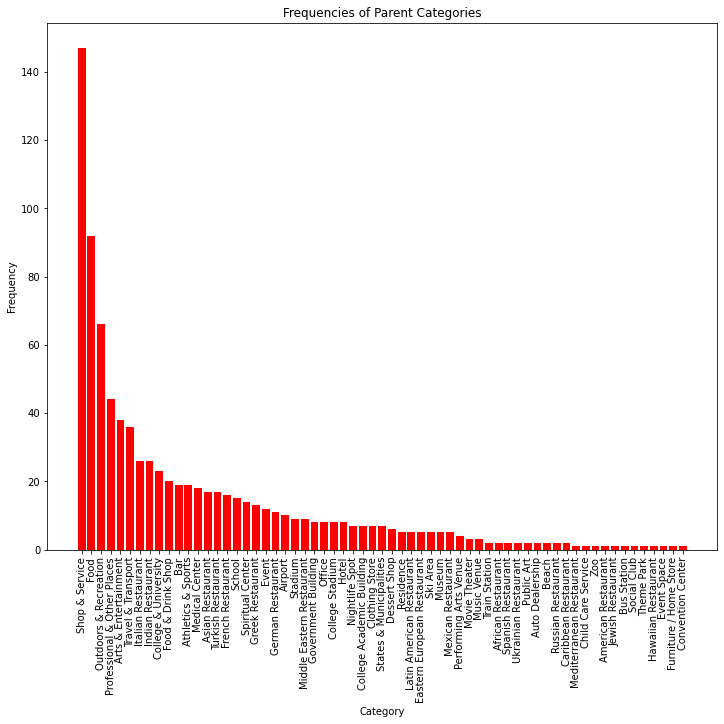

In [66]:
## Get Frequencies of Each Parent Category
hist_frequencies = category_df['parent'].value_counts()
## Get All Corresponding names of the Parent Categories
hist_labels      = hist_frequencies.index.values
X = [i for i in range(len(hist_labels))] ## X Axis
Y = hist_frequencies.values ## Y Axis

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(1,1,1)
ax.bar(X,Y, color='red')
ax.set_xticks(X)
## Display Parent Category Names instead of Index Number
ax.set_xticklabels(hist_labels,rotation=90)
ax.set_xlabel('Category')
ax.set_ylabel('Frequency')
ax.set_title('Frequencies of Parent Categories')
## Add More spacing between X Ticks
fig.tight_layout(pad=0.5)

Now that we have the `category_id` value *found*, we can now do **api search** from **FourSquare** on that
category id to locate all the venues in the *Los Angeles* area that belong to that category.

From all those **retrieved venues**, we can search for the ***venue's details*** through another API call
to get **additional details for each venue**

Since this can result in many *api requests*, we must **limit the amount of venues retrieved** in our search api call. 

To create the initial dataset for clustering and later overlaying to the `Folium Map`, as well as the popup menu, we will need:
* Latitude
* Longitude
* Name

For our clustering algorithm, we need to gather some of the categories and listings that a venue *belongs to*, from there
venues that share *more common listings, categories* should be more likely to belong to the *same cluster*.

These **categorical attributes** are:
* `parent-category` (the category of the venue's parent if present, otherwise `None`
* `category` (list of categories a venue belongs to
* `listings` (list of listings in Foursquare associated with venue)
* `verified`[encoded as `1` or `0`], as a way to examine the reputation and engagement of the venue in Foursquare
* `chain` (Whether the venue is an independent store or part of a larger franchise [think of Disney Store / Lego Store] )

Some of these attribute may need to be **one-hot-encoded** or remapped as additional *binary* attributes.

There are also several **continuous / numerical attributes**.
* `ratings` (The average score by users)
* `ratingSignals` (To see how much engaged the venue is with FourSquare users)
* `likes` (Way to measure reputation and engagement with users)
* `tipcount` (Way to measure the level of engagement and activity users have at that venue
* `photos` (Way to measure how the venue makes use of media and advertising for its own promotion

In [68]:
def fetch_venue_by_id(url,venue_id,client_id,client_secret,version):
    data = {'categories':[],'tipcount':0,'rating':0.0,'likes':0,'chain':0,'photos':0,'parent-category':None,'listings':[],'ratingSignals':0,'verified':0}
    api_url  = url.format(venue_id,client_id,client_secret,version)
    json     = requests.get(api_url).json()
    if 'response' in json and 'venue' in json['response']:
        venue = json['response']['venue']
        for cat in json['response']['venue']['categories']:
            data['categories'].append(cat['name'])
        data['tipcount'] = json['response']['venue']['stats']['tipCount']
        if 'rating' in venue:
            data['rating'] = venue['rating']
        data['likes']     = venue['likes']['count']
        if 'page' in venue and 'user' in venue['page'] and 'type' in venue['page']['user']:
            if venue['page']['user']['type'] == 'chain':
                data['chain'] = 1
        if venue['verified']:
            data['verified'] = 1
        if 'parent' in venue and 'categories' in venue['parent'] and len(venue['parent']['categories']) > 0:
            data['parent-category'] = venue['parent']['categories'][0]['name']
        if 'ratingSignals' in venue:
            data['ratingSignals'] = venue['ratingSignals']
        if 'photos' in venue:
            data['photos'] = venue['photos']['count']
        if 'listed' in venue and 'groups' in venue['listed']:
            for group in venue['listed']['groups']:
                if 'items' in group:
                    for item in group['items']:
                        data['listings'].append(item['name'])
    return data


def fetch_venues(url,id_url,client_id,client_secret,version,near,radius,category_id,limit):
    #other_url = 'http://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near={}&sortByPopularity=1&radius={}&query=toy&limit={}'
    #api_url   = other_url.format(client_id,client_secret,version,near,radius,limit)
    api_url = url.format(client_id,client_secret,version,near,radius,category_id,limit)
    json    = requests.get(api_url).json()
    result  = []
    table   = {
        'name':[],
        'id':[],
        'address':[],
        'latitude':[],
        'longitude':[],
        'categories':[],
        'photos':[],
        'parent-categories':[],
        'listings':[],
        'verified':[],
        'chain':[],
        'tips':[],
        'likes':[],
        'rating':[],
        'ratingSignals':[]
    }
    if 'response' in json and 'venues' in json['response']:
        for venue in json['response']['venues']:
            table['name'].append(venue['name'])
            table['id'].append(venue['id'])
            address = ''
            if 'location' in venue and 'address' in venue['location']:
                address = venue['location']['address']
            table['address'].append(address)
            table['latitude'].append(venue['location']['lat'])
            table['longitude'].append(venue['location']['lng'])
            categories = []
            parent_categories = []
            listings = []
            if 'categories' in venue:
                for cat in venue['categories']:
                    categories.append(cat['name'])
            venue_data = fetch_venue_by_id(id_url,venue['id'],client_id,client_secret,version)
            for cat in venue_data['categories']:
                categories.append(cat)
            for listing in venue_data['listings']:
                listings.append(listing)
            table['photos'].append(venue_data['photos'])
            table['verified'].append(venue_data['verified'])
            table['chain'].append(venue_data['chain'])
            table['rating'].append(venue_data['rating'])
            table['ratingSignals'].append(venue_data['ratingSignals'])
            table['likes'].append(venue_data['likes'])
            table['tips'].append(venue_data['tipcount'])
            table['parent-categories'].append(venue_data['parent-category'])
            table['categories'].append(list(set(categories)))
            table['listings'].append(list(set(listings)))
    return pd.DataFrame(data=table)                                                                                            

df = fetch_venues(venue_search_url,venue_id_api_url,CLIENT_ID,CLIENT_SECRET,VERSION,LOCATION,50000,cat_id,LIMIT) 
df.head()

,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,likes,rating,ratingSignals
0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,"[Toy / Game Store, Hobby Shop]",91,Shopping Mall,"[L.A. to do, Vinyl Figures and Toys, Favorite ...",0,0,16,54,7.7,77
1,Game Chest,5faf537db2e12c113624a98c,,34.135820,-118.052040,[Toy / Game Store],0,Shopping Mall,[],0,0,0,0,0.0,0
2,Mind Games,5d1804bc4dcbca0023d181ec,,34.133780,-118.049045,[Toy / Game Store],1,Shopping Mall,[],0,0,0,0,0.0,0
3,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,"[Toy / Game Store, Bookstore]",9,None,"[Los Angeles VI, The 10 Most Fun Toy Stores in...",0,0,6,10,7.3,15
4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[Toy / Game Store, Hobby Shop, General Enterta...",3,Shopping Mall,[],0,0,0,0,0.0,0


### Data Preprocessing

#### Ordinal Encoding
The first column to preprocess is the `parent-categories` column.

Since this column can only have **one label**, we will use simply ***Ordinal Encoding***,
to replace the `parent-categories` column with its *encoded values*

In [96]:
from collections import defaultdict
import ast, csv

csv_str = 'index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,likes,rating,ratingSignals\n0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.04940820143631,-118.24074895474419,"[\'Hobby Shop\', \'Toy / Game Store\']",91,2.0,"[\'マンガやアニメの画像 Best Manga & Anime Images\', \'L.A. to do\', \'Vinyl Figures and Toys\', \'Favorite places to not get laid!\']",0,0,16,54,7.6,77\n1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[\'Toy / Game Store\'],0,2.0,[],0,0,0,0,0.0,0\n2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.11597814650485,-118.15119887952677,"[\'Bookstore\', \'Toy / Game Store\']",9,0.0,"[\'The 10 Most Fun Toy Stores in America\', \'Places to Try\', \'Places to go, things to do\', \'Los Angeles VI\']",0,0,6,10,7.3,15\n3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[\'Shopping Plaza\', \'Theme Park Ride / Attraction\', \'Toy / Game Store\']",0,2.0,[],0,0,0,0,6.9,0\n4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[\'General Entertainment\', \'Hobby Shop\', \'Toy / Game Store\']",3,2.0,[],0,0,0,0,0.0,0\n5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.80208909072817,-117.93923196926463,[\'Toy / Game Store\'],4,0.0,[],0,0,0,3,0.0,0\n6,Mind Games,5d1804bc4dcbca0023d181ec,,34.13378,-118.049045,[\'Toy / Game Store\'],1,2.0,[],0,0,0,0,0.0,0\n7,Game Chest,5faf537db2e12c113624a98c,,34.13582,-118.05204,[\'Toy / Game Store\'],0,2.0,[],0,0,0,0,0.0,0\n8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,[\'Toy / Game Store\'],7,4.0,[],0,0,1,0,0.0,0\n9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.69629785864135,-117.95570239201338,"[\'Miscellaneous Shop\', \'Gift Shop\', \'Toy / Game Store\']",0,0.0,[],0,0,0,0,0.0,0\n10,buybuy BABY,54a70415498e9c8f4ca1d078,22999 Savi Ranch Pkwy,33.8749552483708,-117.734874039888,"[\'Baby Store\', \'Furniture / Home Store\', \'Toy / Game Store\']",3,0.0,[],0,0,2,18,8.5,19\n11,Buybuy Baby,55b55c5b498e550d3f47424e,6621 Fallbrook Ave Unit B,34.190315,-118.6249316,"[\'Baby Store\', \'Furniture / Home Store\', \'Toy / Game Store\']",6,0.0,[],0,0,0,2,6.9,4\n12,Puzzle Zoo,4a88ca4ef964a5209d0720e3,1411 3rd Street Promenade,34.015402370294886,-118.4957467238801,[\'Toy / Game Store\'],72,3.0,"[\'LA Favorites\', \'West Coast 2019\', \'Vinyl Figures and Toys\', \'Favorite places to not get laid!\']",1,1,10,37,8.2,51\n13,Funko Hollywood,5dd2e1c88caaba000855e750,6201 Hollywood Blvd,34.10198,-118.32704,[\'Toy / Game Store\'],60,0.0,"[\'LA To-Dos\', \'California & more #stayhome #after-corona\']",0,0,7,10,8.1,17\n14,Savi\'s Workshop – Handbuilt Lightsabers,5ceeefab8a6f17002ca703eb,1313 Disneyland Dr,33.814383,-117.9210817,[\'Toy / Game Store\'],55,5.0,[\'SNA\'],0,0,3,5,0.0,0\n15,Frank & Son Collectible Show,5e11183eee4361000775d963,17835 Gale Ave,33.995737,-117.914864,"[\'Hobby Shop\', \'Toy / Game Store\']",18,0.0,[],0,0,0,3,0.0,0\n16,The LEGO Store,4d727b2cd976236a590f0779,3333 Bristol St,33.691352067760164,-117.88775427566877,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",121,2.0,"[\'Outdoor Activities\', \'Good Service\']",1,1,8,51,8.3,65\n17,Comics Factory,4b314068f964a520400325e3,1298 E Colorado Blvd,34.145835654555626,-118.12358495263952,[\'Toy / Game Store\'],37,0.0,"[\'BlasterCON Drop Off\', \'Los Angeles - Favorites\', \'L.A Nerdery\', \'The Los Angeles Geek Trail\']",0,0,9,24,8.8,36\n18,Dice House Games,4b6493cff964a52023bf2ae3,2493 E Chapman Ave,33.874520046691835,-117.88739443769106,[\'Toy / Game Store\'],10,0.0,"[\'Game Shops\', \'Boardgames, comics and stuff\']",1,0,4,20,8.2,26\n19,Build-A-Bear Workshop,4ecacdad7ed15381d23f74ad,1 Mills Cir Ste 632,34.07236095202675,-117.55037240824348,"[\'Gift Shop\', \'Toy / Game Store\']",32,2.0,[\'Southern California\'],1,1,2,12,8.0,14\n20,Droid Depot,5cf0d141b9b37b002c2bd946,1313 Disneyland Dr.,33.81418162416658,-117.92081794526484,[\'Toy / Game Store\'],79,5.0,[],0,0,3,11,7.5,14\n21,Main Street Emporium,4ae11f0bf964a520538521e3,Main Street U.S.A.,33.81065419507239,-117.91921030404953,"[\'Gift Shop\', \'Toy / Game Store\']",186,4.0,"[\'My BEST of the BEST!\', \'Disneyland Resort\', \'Shopping\', \'Disneyland\']",1,1,20,143,9.1,167\n22,Giant Robot 2 - GR2 Gallery,49bc472ef964a52023541fe3,2062 Sawtelle Blvd,34.03982309686749,-118.44254622181643,"[\'Toy / Game Store\', \'Art Gallery\']",200,0.0,"[\'The Los Angeles Geek Trail\', \'LA Museum&Gallery\', \'Vinyl Figures and Toys\', \'Art galleries\']",1,0,8,33,8.9,40\n23,Pooh Corner,4a7f1c97f964a520e1f21fe3,Critter Country,33.812165924701425,-117.92316331169019,"[\'Candy Store\', \'Theme Park\', \'Toy / Game Store\']",311,4.0,"[\'Mice & Dice 2011\', \'Welcome to the Tragic Kingdom\', \'Disneyland Fun!!!\', \'Disneyland\']",1,1,30,72,7.8,102\n24,World of Disney,4ab82fc4f964a520817c20e3,1565 S Disneyland Dr,33.8085901,-117.9210194,[\'Toy / Game Store\'],1205,3.0,"[""Guide to Anaheim\'s best spots"", \'33\', \'Disneyland\', \'Disneyland Rides\']",1,1,104,468,9.3,1392\n25,Kip\'s Toyland,4b721c9ef964a520516f2de3,6333 W 3rd St #720,34.072213856538006,-118.36018094747348,[\'Toy / Game Store\'],18,0.0,"[""Chris\' Guide to LA\'s best spots"", \'California 2013\']",0,0,5,11,7.7,14\n26,"""it\'s a small world"" Toy Shop",4f7885bbe4b087957bacee12,Fantasyland,33.814372310117584,-117.91806510404348,"[\'Theme Park\', \'Gift Shop\', \'Toy / Game Store\']",80,4.0,"[\'Funny Toys Gift\', \'Disneyland Resort\']",1,1,2,10,6.5,15\n27,American Girl Doll Store,551afbbf498e1a169ad9faba,,34.072406728239194,-118.35911349222353,[\'Toy / Game Store\'],70,2.0,"[\'لوس انجلس\', \'Places of Interest.\']",0,0,6,14,6.2,25\n28,Blast From The Past,4ab97077f964a520617f20e3,931 N Hollywood Way,34.169807957391924,-118.34186015209193,[\'Toy / Game Store\'],43,0.0,"[\'Our Friends & Sponsors\', \'Favorite Collector stores\', \'L.A Nerdery\', \'Geeking Out in Los Angeles\']",0,0,6,10,7.7,16\n29,(Uncle) Tom\'s Toys,4b0879e9f964a520a50c23e3,2280 Honolulu Ave,34.205427022409786,-118.22756561654226,[\'Toy / Game Store\'],8,0.0,[],0,0,5,9,6.9,15\n30,GamePlay,4ca01b742fb1a143cfecf940,10937 Venice Blvd,34.01562632233249,-118.41305307393706,[\'Toy / Game Store\'],17,0.0,"[\'Shopping  Desires A1\', \'LA Wrecks\']",0,0,7,11,7.9,18\n31,Little Green Men Store Command,4afb386df964a5202d1c22e3,Tomorrowland,33.812161553057585,-117.91753335455093,"[\'Gift Shop\', \'Toy / Game Store\']",37,4.0,"[\'my places\', \'Must-visit Gift Shops in Anaheim\']",1,1,8,7,5.7,18\n32,Disney Store,4b5cefacf964a5208c4b29e3,88 Lakewood Center Mall,33.84967,-118.140729,[\'Toy / Game Store\'],17,2.0,[],1,1,1,17,7.4,22\n33,Disney Store,4b80b9b7f964a5209c8830e3,21712 Hawthorne Blvd,33.832517,-118.349264,[\'Toy / Game Store\'],76,2.0,[\'Places to go to in California\'],1,1,8,21,7.7,30\n34,The LEGO Store,4a6b9f1ef964a52066cf1fe3,2130 Glendale Galleria,34.1451611,-118.2583278,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",172,2.0,"[\'Pasadena\', \'SoCal for Kids\', \'Awesome\', ""LA to do\'s""]",1,1,18,67,8.4,85\n35,Disney store,4b81ce25f964a52011bf30e3,163 Los Cerritos Center,33.862598,-118.095322,[\'Toy / Game Store\'],21,2.0,[\'好きなお店\'],1,1,8,21,7.7,29\n36,Giant Robot Store,4a2dbfc4f964a520ed971fe3,2015 Sawtelle Blvd,34.04046846240436,-118.44343553753704,"[\'Gift Shop\', \'Toy / Game Store\']",89,0.0,"[\'Essential Los Angeles\', \'Eu por aí\', \'LA Top Shops\', \'SoCal Musts\']",1,0,3,47,8.6,57\n37,Disney Store,4bca7467937ca593a706a892,1 Mills Circle,34.072314,-117.55034,[\'Toy / Game Store\'],28,2.0,[\'favorite places\'],1,1,2,50,7.7,67\n38,Disney Store,52844d4111d2e86d67d25246,100 Citadel Drive,34.006371,-118.149658,[\'Toy / Game Store\'],33,1.0,"[\'LA & Cali\', \'Fun Things\']",1,1,6,41,8.7,148\n39,Disney store,4b858efcf964a520636531e3,3333 Bristol Street,33.691405,-117.887253,[\'Toy / Game Store\'],87,2.0,"[\'CA\', \'California 2014\']",1,1,3,30,7.8,40\n40,The LEGO Store,4abfaaa6f964a5208c9120e3,1585 S Disneyland Dr,33.80880954662581,-117.92440479695892,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",1494,3.0,"[\'USA Road Trip 2019\', ""Guide to Anaheim\'s best spots"", \'Out of Michigan\', \'Vinyl Figures and Toys\']",1,1,55,337,8.9,413\n41,Disney store,4b716788f964a520ed442de3,6000 Sepulveda Blvd.,33.98608,-118.392327,[\'Toy / Game Store\'],43,2.0,[\'Los Angeles\'],1,1,4,19,8.0,29\n42,Big Top Toys,4fd850800cd67bad75a9dafc,"Disney California Adventure Park, Buena Vista Street",33.8082254,-117.9188182,[\'Toy / Game Store\'],5,5.0,[\'dca\'],1,1,0,4,0.0,0\n43,Disney Store,4ba954f0f964a5207e1f3ae3,1152 Glendale Galleria,34.144838,-118.258415,[\'Toy / Game Store\'],145,2.0,"[\'Los Angeles\', \'What should I do today? Oh I can go here!\', \'toys and games\', \'California\']",1,1,7,50,8.7,62\n44,Disney store,4cb0d4e2ef1b370493703e00,5060 East Montclair Plaza Lane,34.087097,-117.694681,[\'Toy / Game Store\'],12,0.0,"[\'Best Spots to Visit\', \'Tinkys faves\']",1,1,0,15,7.6,19\n45,Disney store,4bba4c3dcf2fc9b64c61a102,2800 North Main Street,33.774777,-117.869893,[\'Toy / Game Store\'],29,0.0,"[\'Favorite places\', \'California\']",1,1,4,24,7.8,28\n46,Disney store,4ce9c67d595cb1f79ea7d014,14006 Riverside Drive,34.15722917,-118.4368377,[\'Toy / Game Store\'],45,2.0,"[\'... V\', \'Places My Son Loves\']",1,1,2,11,7.5,18\n47,Disney,502a816bd63e645b656beb86,732 Americana Way,34.144139,-118.255558,[\'Toy / Game Store\'],22,3.0,"[\'Glendale\', \'toys and games\']",1,1,3,19,8.1,23\n48,Disney store,4c1a39e5834e2d7f3c872b80,2060 Montebello Town Center,34.036015,-118.084315,[\'Toy / Game Store\'],45,2.0,"[\'What should I do today? Oh I can go here!\', \'California\']",1,1,6,8,5.7,20\n49,FYE,4bb41b5b0cbcef3bb6be582a,2024 Montebello Town Ctr,34.0360584,-118.0853085,"[\'Music Store\', \'Electronics Store\', \'Toy / Game Store\']",27,2.0,[\'Los Angeles\'],1,1,2,7,7.3,10\n'
csv_arr = [row for row in csv.reader(csv_str.split('\n'),delimiter=',')]
csv_arr = csv_arr[1:]

float_columns = ['latitude','longitude','rating']
int_columns   = ['index','photos','verified','chain','tips','likes']
list_columns  = ['categories','listings']

def csv_str_to_df(csv_str,float_columns=[],int_columns=[],list_columns=[]):
    csv_arr = [row for row in csv.reader(csv_str.split('\n'),delimiter=',')]
    columns = csv_arr[0]
    data    = csv_arr[1:-1]
    mapping = defaultdict(list)
    for row in data:
        for i in range(len(row)):
            mapping[columns[i]].append(row[i])
    df = pd.DataFrame(data=data,columns=columns)
    for c in float_columns:
        df[c] = df[c].astype(float)
    for c in int_columns:
        df[c] = df[c].astype(int)
    for c in list_columns:
        df[c] = df[c].apply(lambda x : ast.literal_eval(x))
    return df
            
df = csv_str_to_df(csv_str,float_columns,int_columns,list_columns)
df

,index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,likes,rating,ratingSignals
0,0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,"[Hobby Shop, Toy / Game Store]",91,2.0,"[マンガやアニメの画像 Best Manga & Anime Images, L.A. to...",0,0,16,54,7.6,77
1,1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[Toy / Game Store],0,2.0,[],0,0,0,0,0.0,0
2,2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,"[Bookstore, Toy / Game Store]",9,0.0,"[The 10 Most Fun Toy Stores in America, Places...",0,0,6,10,7.3,15
3,3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[Shopping Plaza, Theme Park Ride / Attraction,...",0,2.0,[],0,0,0,0,6.9,0
4,4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[General Entertainment, Hobby Shop, Toy / Game...",3,2.0,[],0,0,0,0,0.0,0
5,5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.802089,-117.939232,[Toy / Game Store],4,0.0,[],0,0,0,3,0.0,0
6,6,Mind Games,5d1804bc4dcbca0023d181ec,,34.133780,-118.049045,[Toy / Game Store],1,2.0,[],0,0,0,0,0.0,0
7,7,Game Chest,5faf537db2e12c113624a98c,,34.135820,-118.052040,[Toy / Game Store],0,2.0,[],0,0,0,0,0.0,0
8,8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,[Toy / Game Store],7,4.0,[],0,0,1,0,0.0,0
9,9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.696298,-117.955702,"[Miscellaneous Shop, Gift Shop, Toy / Game Store]",0,0.0,[],0,0,0,0,0.0,0


For the categorical variable we can ***ordinally encode***, as well as the *numerical variables*,
the distribution in the dataset can be visualized with a **bar chart and histogram respectively**.

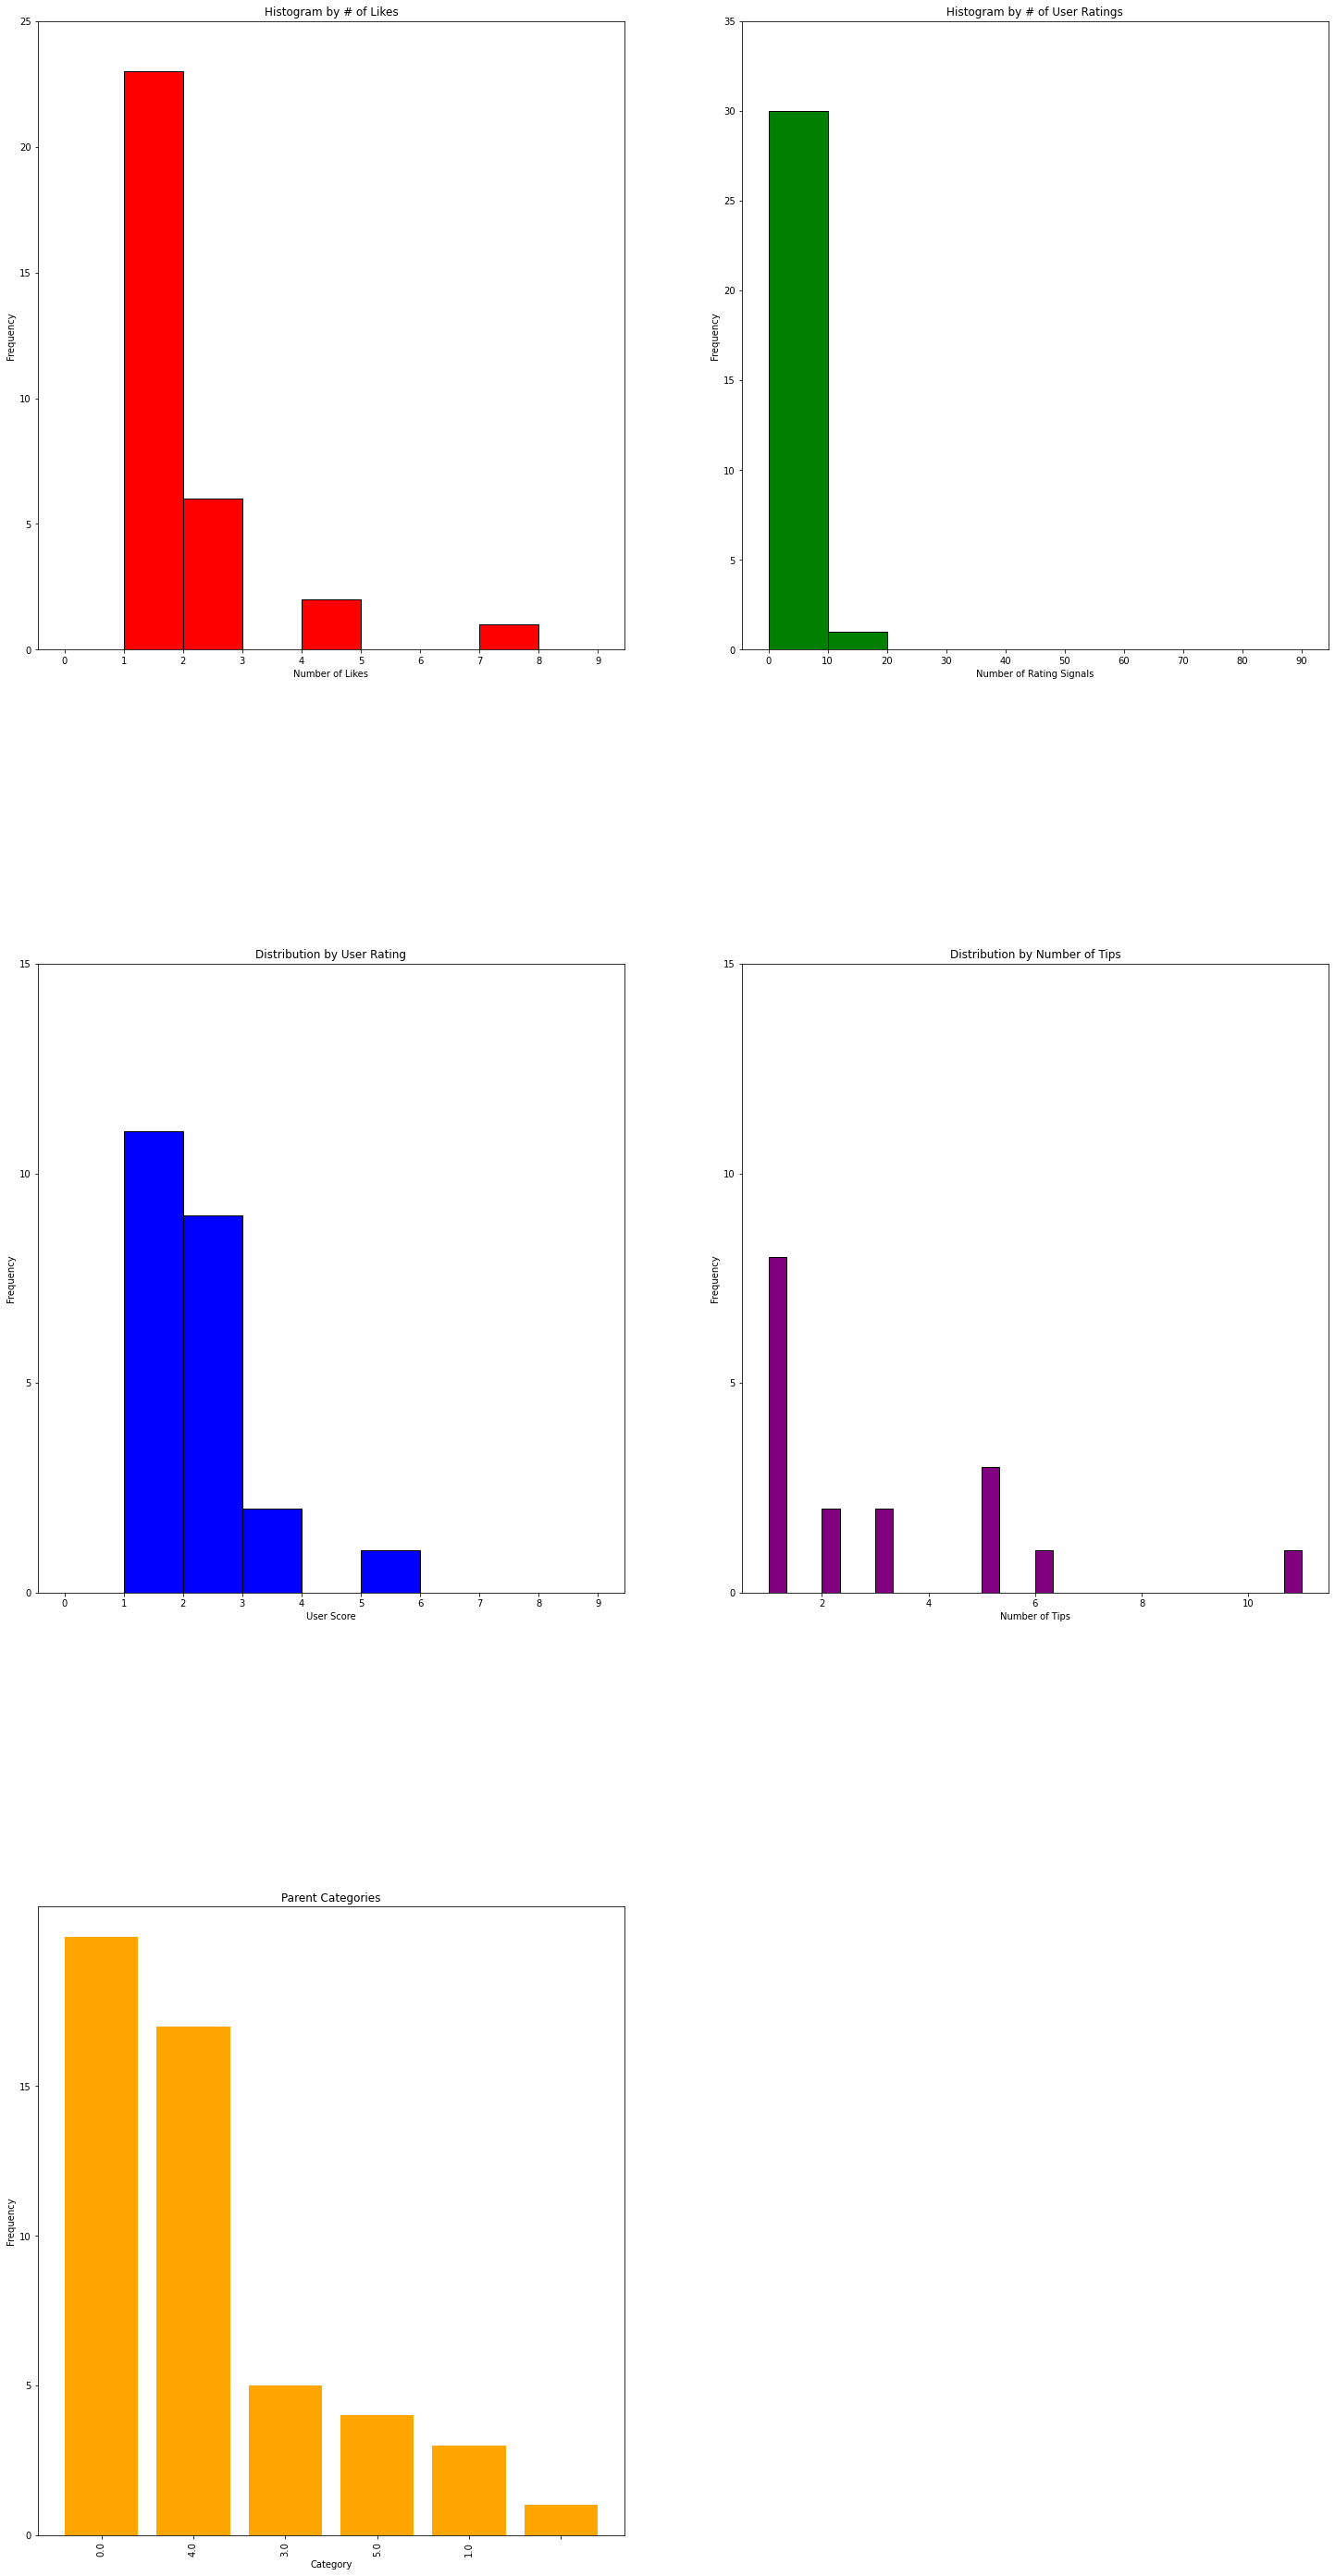

In [97]:
### Histogram Configurations for Each Column in the Joined Dataset
hist_data = [
    {
        "column":"likes",
        "xlabel":"Number of Likes",
        "ylabel":"Frequency",
        "title":"Histogram by # of Likes",
        "color":"red",
        "type":"hist",
        "bins":np.arange(0,10),
        "xticks":np.arange(0,10),
        "max":30
    },
    {
        "column":"ratingSignals",
        "xlabel":"Number of Rating Signals",
        "ylabel":"Frequency",
        "title":"Histogram by # of User Ratings",
        "type":"hist",
        "bins":np.arange(0,100,10),
        "xticks":np.arange(0,100,10),
        "max":40,
        "color":"green"
    },
    {
        "column":"rating",
        "xlabel":"User Score",
        "ylabel":"Frequency",
        "title":"Distribution by User Rating",
        "type":"hist",
        "bins":np.arange(0,10.0),
        "xticks":np.arange(0,10.0),
        "color":"blue"
    },
    {
        "column":"tips",
        "xlabel":"Number of Tips",
        "ylabel":"Frequency",
        "title":"Distribution by Number of Tips",
        "type":"hist",
        "bins":30,
        "color":"purple"
    },
    {
        "column":"parent-categories",
        "xlabel":"Category",
        "ylabel":"Frequency",
        "title":"Parent Categories",
        "type":"bar",
        "bins":10,
        "color":"orange"
    }
]

def render_histograms(df,hist_data,num_rows,num_cols,figsize=(25,50)):
    figure = plt.figure(figsize=figsize)
    for i,datum in enumerate(hist_data):
        data = df[datum['column']].value_counts()
        X    = data.index.values ## Get unique labels for each value counts
        Y    = data.values ## Get Frequencies
        bins   = datum['bins'] 
        ## Add subgraph to the next available column
        ax = figure.add_subplot(num_rows,num_cols,i+1)
        if datum['type'] == 'hist':
            ## Create histogram
            ax.hist(Y,bins,color=datum['color'],edgecolor='black',linewidth=1)
        elif datum['type'] == 'bar':
            ## Create Bar Chart
            ax.bar([i for i in range(X.shape[0])],Y,color=datum['color'])
            ## Use Labels as X tick labels instead of numbers
            ax.set_xticklabels(list(map(lambda x : x if x is not None and x != "" else "N/A",X)),rotation=90)
        ax.set_xlabel(datum['xlabel'])
        ax.set_ylabel(datum['ylabel'])
        if "xticks" in datum:
            ax.set_xticks(datum['xticks'])
        maximum = 20 ## Default Y Max
        if "max" in datum:
            maximum = datum['max']
        #ax.set_xticks([i for i in range(1,bins+1)])
        ax.set_yticks([i for i in range(0,maximum,5)])
        ax.set_title(datum['title'])
    plt.subplots_adjust(hspace=0.5)

render_histograms(df,hist_data,3,2)

In [98]:


integer_columns = ['photos','tips','likes','rating','ratingSignals']
ordinal_encoder = OrdinalEncoder()
df['parent-categories'].replace(np.nan,"",inplace=True)
df['parent-categories']= ordinal_encoder.fit_transform(df['parent-categories'].values.reshape(-1,1))

for c in integer_columns:
    df[c] = df[c].astype(float)
df

,index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,likes,rating,ratingSignals
0,0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,"[Hobby Shop, Toy / Game Store]",91.0,2.0,"[マンガやアニメの画像 Best Manga & Anime Images, L.A. to...",0,0,16.0,54.0,7.6,77.0
1,1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[Toy / Game Store],0.0,2.0,[],0,0,0.0,0.0,0.0,0.0
2,2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,"[Bookstore, Toy / Game Store]",9.0,0.0,"[The 10 Most Fun Toy Stores in America, Places...",0,0,6.0,10.0,7.3,15.0
3,3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[Shopping Plaza, Theme Park Ride / Attraction,...",0.0,2.0,[],0,0,0.0,0.0,6.9,0.0
4,4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[General Entertainment, Hobby Shop, Toy / Game...",3.0,2.0,[],0,0,0.0,0.0,0.0,0.0
5,5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.802089,-117.939232,[Toy / Game Store],4.0,0.0,[],0,0,0.0,3.0,0.0,0.0
6,6,Mind Games,5d1804bc4dcbca0023d181ec,,34.133780,-118.049045,[Toy / Game Store],1.0,2.0,[],0,0,0.0,0.0,0.0,0.0
7,7,Game Chest,5faf537db2e12c113624a98c,,34.135820,-118.052040,[Toy / Game Store],0.0,2.0,[],0,0,0.0,0.0,0.0,0.0
8,8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,[Toy / Game Store],7.0,4.0,[],0,0,1.0,0.0,0.0,0.0
9,9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.696298,-117.955702,"[Miscellaneous Shop, Gift Shop, Toy / Game Store]",0.0,0.0,[],0,0,0.0,0.0,0.0,0.0


#### Removing Highly Correlated Variables
Since social media metrics like the **number of likes** and **venue rating**, it might be worth 
checking if these *covary* with each other, possibly making them redundant. 

Also, since the numerical variables in this dataset are on different scales, these numbers should be
standardized with `StandardScaler`.

From there, the **correlation matrix** of the dataset can be calculated and from there; if any
column pairs *correlate with each other above a certain threshold* (i.e `0.95`), one of those features can
be *removed*.

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,rating,ratingSignals
0,0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,"[Hobby Shop, Toy / Game Store]",91.0,2.0,"[マンガやアニメの画像 Best Manga & Anime Images, L.A. to...",0,0,16.0,7.6,77.0
1,1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[Toy / Game Store],0.0,2.0,[],0,0,0.0,0.0,0.0
2,2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,"[Bookstore, Toy / Game Store]",9.0,0.0,"[The 10 Most Fun Toy Stores in America, Places...",0,0,6.0,7.3,15.0
3,3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[Shopping Plaza, Theme Park Ride / Attraction,...",0.0,2.0,[],0,0,0.0,6.9,0.0
4,4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[General Entertainment, Hobby Shop, Toy / Game...",3.0,2.0,[],0,0,0.0,0.0,0.0
5,5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.802089,-117.939232,[Toy / Game Store],4.0,0.0,[],0,0,0.0,0.0,0.0
6,6,Mind Games,5d1804bc4dcbca0023d181ec,,34.133780,-118.049045,[Toy / Game Store],1.0,2.0,[],0,0,0.0,0.0,0.0
7,7,Game Chest,5faf537db2e12c113624a98c,,34.135820,-118.052040,[Toy / Game Store],0.0,2.0,[],0,0,0.0,0.0,0.0
8,8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,[Toy / Game Store],7.0,4.0,[],0,0,1.0,0.0,0.0
9,9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.696298,-117.955702,"[Miscellaneous Shop, Gift Shop, Toy / Game Store]",0.0,0.0,[],0,0,0.0,0.0,0.0


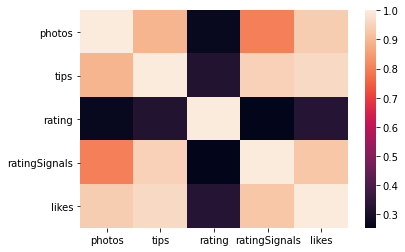

In [99]:
from io import StringIO
from sklearn.preprocessing import StandardScaler 
import csv, ast

json_str = df.to_csv()


csv_str = 'index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,verified,chain,tips,likes,rating,ratingSignals\n0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.04940820143631,-118.24074895474419,"[\'Hobby Shop\', \'Toy / Game Store\']",91,2.0,"[\'マンガやアニメの画像 Best Manga & Anime Images\', \'L.A. to do\', \'Vinyl Figures and Toys\', \'Favorite places to not get laid!\']",0,0,16,54,7.6,77\n1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[\'Toy / Game Store\'],0,2.0,[],0,0,0,0,0.0,0\n2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.11597814650485,-118.15119887952677,"[\'Bookstore\', \'Toy / Game Store\']",9,0.0,"[\'The 10 Most Fun Toy Stores in America\', \'Places to Try\', \'Places to go, things to do\', \'Los Angeles VI\']",0,0,6,10,7.3,15\n3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[\'Shopping Plaza\', \'Theme Park Ride / Attraction\', \'Toy / Game Store\']",0,2.0,[],0,0,0,0,6.9,0\n4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[\'General Entertainment\', \'Hobby Shop\', \'Toy / Game Store\']",3,2.0,[],0,0,0,0,0.0,0\n5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.80208909072817,-117.93923196926463,[\'Toy / Game Store\'],4,0.0,[],0,0,0,3,0.0,0\n6,Mind Games,5d1804bc4dcbca0023d181ec,,34.13378,-118.049045,[\'Toy / Game Store\'],1,2.0,[],0,0,0,0,0.0,0\n7,Game Chest,5faf537db2e12c113624a98c,,34.13582,-118.05204,[\'Toy / Game Store\'],0,2.0,[],0,0,0,0,0.0,0\n8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,[\'Toy / Game Store\'],7,4.0,[],0,0,1,0,0.0,0\n9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.69629785864135,-117.95570239201338,"[\'Miscellaneous Shop\', \'Gift Shop\', \'Toy / Game Store\']",0,0.0,[],0,0,0,0,0.0,0\n10,buybuy BABY,54a70415498e9c8f4ca1d078,22999 Savi Ranch Pkwy,33.8749552483708,-117.734874039888,"[\'Baby Store\', \'Furniture / Home Store\', \'Toy / Game Store\']",3,0.0,[],0,0,2,18,8.5,19\n11,Buybuy Baby,55b55c5b498e550d3f47424e,6621 Fallbrook Ave Unit B,34.190315,-118.6249316,"[\'Baby Store\', \'Furniture / Home Store\', \'Toy / Game Store\']",6,0.0,[],0,0,0,2,6.9,4\n12,Puzzle Zoo,4a88ca4ef964a5209d0720e3,1411 3rd Street Promenade,34.015402370294886,-118.4957467238801,[\'Toy / Game Store\'],72,3.0,"[\'LA Favorites\', \'West Coast 2019\', \'Vinyl Figures and Toys\', \'Favorite places to not get laid!\']",1,1,10,37,8.2,51\n13,Funko Hollywood,5dd2e1c88caaba000855e750,6201 Hollywood Blvd,34.10198,-118.32704,[\'Toy / Game Store\'],60,0.0,"[\'LA To-Dos\', \'California & more #stayhome #after-corona\']",0,0,7,10,8.1,17\n14,Savi\'s Workshop – Handbuilt Lightsabers,5ceeefab8a6f17002ca703eb,1313 Disneyland Dr,33.814383,-117.9210817,[\'Toy / Game Store\'],55,5.0,[\'SNA\'],0,0,3,5,0.0,0\n15,Frank & Son Collectible Show,5e11183eee4361000775d963,17835 Gale Ave,33.995737,-117.914864,"[\'Hobby Shop\', \'Toy / Game Store\']",18,0.0,[],0,0,0,3,0.0,0\n16,The LEGO Store,4d727b2cd976236a590f0779,3333 Bristol St,33.691352067760164,-117.88775427566877,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",121,2.0,"[\'Outdoor Activities\', \'Good Service\']",1,1,8,51,8.3,65\n17,Comics Factory,4b314068f964a520400325e3,1298 E Colorado Blvd,34.145835654555626,-118.12358495263952,[\'Toy / Game Store\'],37,0.0,"[\'BlasterCON Drop Off\', \'Los Angeles - Favorites\', \'L.A Nerdery\', \'The Los Angeles Geek Trail\']",0,0,9,24,8.8,36\n18,Dice House Games,4b6493cff964a52023bf2ae3,2493 E Chapman Ave,33.874520046691835,-117.88739443769106,[\'Toy / Game Store\'],10,0.0,"[\'Game Shops\', \'Boardgames, comics and stuff\']",1,0,4,20,8.2,26\n19,Build-A-Bear Workshop,4ecacdad7ed15381d23f74ad,1 Mills Cir Ste 632,34.07236095202675,-117.55037240824348,"[\'Gift Shop\', \'Toy / Game Store\']",32,2.0,[\'Southern California\'],1,1,2,12,8.0,14\n20,Droid Depot,5cf0d141b9b37b002c2bd946,1313 Disneyland Dr.,33.81418162416658,-117.92081794526484,[\'Toy / Game Store\'],79,5.0,[],0,0,3,11,7.5,14\n21,Main Street Emporium,4ae11f0bf964a520538521e3,Main Street U.S.A.,33.81065419507239,-117.91921030404953,"[\'Gift Shop\', \'Toy / Game Store\']",186,4.0,"[\'My BEST of the BEST!\', \'Disneyland Resort\', \'Shopping\', \'Disneyland\']",1,1,20,143,9.1,167\n22,Giant Robot 2 - GR2 Gallery,49bc472ef964a52023541fe3,2062 Sawtelle Blvd,34.03982309686749,-118.44254622181643,"[\'Toy / Game Store\', \'Art Gallery\']",200,0.0,"[\'The Los Angeles Geek Trail\', \'LA Museum&Gallery\', \'Vinyl Figures and Toys\', \'Art galleries\']",1,0,8,33,8.9,40\n23,Pooh Corner,4a7f1c97f964a520e1f21fe3,Critter Country,33.812165924701425,-117.92316331169019,"[\'Candy Store\', \'Theme Park\', \'Toy / Game Store\']",311,4.0,"[\'Mice & Dice 2011\', \'Welcome to the Tragic Kingdom\', \'Disneyland Fun!!!\', \'Disneyland\']",1,1,30,72,7.8,102\n24,World of Disney,4ab82fc4f964a520817c20e3,1565 S Disneyland Dr,33.8085901,-117.9210194,[\'Toy / Game Store\'],1205,3.0,"[""Guide to Anaheim\'s best spots"", \'33\', \'Disneyland\', \'Disneyland Rides\']",1,1,104,468,9.3,1392\n25,Kip\'s Toyland,4b721c9ef964a520516f2de3,6333 W 3rd St #720,34.072213856538006,-118.36018094747348,[\'Toy / Game Store\'],18,0.0,"[""Chris\' Guide to LA\'s best spots"", \'California 2013\']",0,0,5,11,7.7,14\n26,"""it\'s a small world"" Toy Shop",4f7885bbe4b087957bacee12,Fantasyland,33.814372310117584,-117.91806510404348,"[\'Theme Park\', \'Gift Shop\', \'Toy / Game Store\']",80,4.0,"[\'Funny Toys Gift\', \'Disneyland Resort\']",1,1,2,10,6.5,15\n27,American Girl Doll Store,551afbbf498e1a169ad9faba,,34.072406728239194,-118.35911349222353,[\'Toy / Game Store\'],70,2.0,"[\'لوس انجلس\', \'Places of Interest.\']",0,0,6,14,6.2,25\n28,Blast From The Past,4ab97077f964a520617f20e3,931 N Hollywood Way,34.169807957391924,-118.34186015209193,[\'Toy / Game Store\'],43,0.0,"[\'Our Friends & Sponsors\', \'Favorite Collector stores\', \'L.A Nerdery\', \'Geeking Out in Los Angeles\']",0,0,6,10,7.7,16\n29,(Uncle) Tom\'s Toys,4b0879e9f964a520a50c23e3,2280 Honolulu Ave,34.205427022409786,-118.22756561654226,[\'Toy / Game Store\'],8,0.0,[],0,0,5,9,6.9,15\n30,GamePlay,4ca01b742fb1a143cfecf940,10937 Venice Blvd,34.01562632233249,-118.41305307393706,[\'Toy / Game Store\'],17,0.0,"[\'Shopping  Desires A1\', \'LA Wrecks\']",0,0,7,11,7.9,18\n31,Little Green Men Store Command,4afb386df964a5202d1c22e3,Tomorrowland,33.812161553057585,-117.91753335455093,"[\'Gift Shop\', \'Toy / Game Store\']",37,4.0,"[\'my places\', \'Must-visit Gift Shops in Anaheim\']",1,1,8,7,5.7,18\n32,Disney Store,4b5cefacf964a5208c4b29e3,88 Lakewood Center Mall,33.84967,-118.140729,[\'Toy / Game Store\'],17,2.0,[],1,1,1,17,7.4,22\n33,Disney Store,4b80b9b7f964a5209c8830e3,21712 Hawthorne Blvd,33.832517,-118.349264,[\'Toy / Game Store\'],76,2.0,[\'Places to go to in California\'],1,1,8,21,7.7,30\n34,The LEGO Store,4a6b9f1ef964a52066cf1fe3,2130 Glendale Galleria,34.1451611,-118.2583278,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",172,2.0,"[\'Pasadena\', \'SoCal for Kids\', \'Awesome\', ""LA to do\'s""]",1,1,18,67,8.4,85\n35,Disney store,4b81ce25f964a52011bf30e3,163 Los Cerritos Center,33.862598,-118.095322,[\'Toy / Game Store\'],21,2.0,[\'好きなお店\'],1,1,8,21,7.7,29\n36,Giant Robot Store,4a2dbfc4f964a520ed971fe3,2015 Sawtelle Blvd,34.04046846240436,-118.44343553753704,"[\'Gift Shop\', \'Toy / Game Store\']",89,0.0,"[\'Essential Los Angeles\', \'Eu por aí\', \'LA Top Shops\', \'SoCal Musts\']",1,0,3,47,8.6,57\n37,Disney Store,4bca7467937ca593a706a892,1 Mills Circle,34.072314,-117.55034,[\'Toy / Game Store\'],28,2.0,[\'favorite places\'],1,1,2,50,7.7,67\n38,Disney Store,52844d4111d2e86d67d25246,100 Citadel Drive,34.006371,-118.149658,[\'Toy / Game Store\'],33,1.0,"[\'LA & Cali\', \'Fun Things\']",1,1,6,41,8.7,148\n39,Disney store,4b858efcf964a520636531e3,3333 Bristol Street,33.691405,-117.887253,[\'Toy / Game Store\'],87,2.0,"[\'CA\', \'California 2014\']",1,1,3,30,7.8,40\n40,The LEGO Store,4abfaaa6f964a5208c9120e3,1585 S Disneyland Dr,33.80880954662581,-117.92440479695892,"[\'Gift Shop\', \'Hobby Shop\', \'Toy / Game Store\']",1494,3.0,"[\'USA Road Trip 2019\', ""Guide to Anaheim\'s best spots"", \'Out of Michigan\', \'Vinyl Figures and Toys\']",1,1,55,337,8.9,413\n41,Disney store,4b716788f964a520ed442de3,6000 Sepulveda Blvd.,33.98608,-118.392327,[\'Toy / Game Store\'],43,2.0,[\'Los Angeles\'],1,1,4,19,8.0,29\n42,Big Top Toys,4fd850800cd67bad75a9dafc,"Disney California Adventure Park, Buena Vista Street",33.8082254,-117.9188182,[\'Toy / Game Store\'],5,5.0,[\'dca\'],1,1,0,4,0.0,0\n43,Disney Store,4ba954f0f964a5207e1f3ae3,1152 Glendale Galleria,34.144838,-118.258415,[\'Toy / Game Store\'],145,2.0,"[\'Los Angeles\', \'What should I do today? Oh I can go here!\', \'toys and games\', \'California\']",1,1,7,50,8.7,62\n44,Disney store,4cb0d4e2ef1b370493703e00,5060 East Montclair Plaza Lane,34.087097,-117.694681,[\'Toy / Game Store\'],12,0.0,"[\'Best Spots to Visit\', \'Tinkys faves\']",1,1,0,15,7.6,19\n45,Disney store,4bba4c3dcf2fc9b64c61a102,2800 North Main Street,33.774777,-117.869893,[\'Toy / Game Store\'],29,0.0,"[\'Favorite places\', \'California\']",1,1,4,24,7.8,28\n46,Disney store,4ce9c67d595cb1f79ea7d014,14006 Riverside Drive,34.15722917,-118.4368377,[\'Toy / Game Store\'],45,2.0,"[\'... V\', \'Places My Son Loves\']",1,1,2,11,7.5,18\n47,Disney,502a816bd63e645b656beb86,732 Americana Way,34.144139,-118.255558,[\'Toy / Game Store\'],22,3.0,"[\'Glendale\', \'toys and games\']",1,1,3,19,8.1,23\n48,Disney store,4c1a39e5834e2d7f3c872b80,2060 Montebello Town Center,34.036015,-118.084315,[\'Toy / Game Store\'],45,2.0,"[\'What should I do today? Oh I can go here!\', \'California\']",1,1,6,8,5.7,20\n49,FYE,4bb41b5b0cbcef3bb6be582a,2024 Montebello Town Ctr,34.0360584,-118.0853085,"[\'Music Store\', \'Electronics Store\', \'Toy / Game Store\']",27,2.0,[\'Los Angeles\'],1,1,2,7,7.3,10\n'
csv_arr = [row for row in csv.reader(csv_str.split('\n'),delimiter=',')]
csv_arr = csv_arr[1:]

## Continuous Features
numerical_columns = ['photos','tips','rating','ratingSignals','likes']

def remove_multicollinear_columns(df,numerical_columns=[]):
    scaler  = StandardScaler()
    df_copy = df.copy()
    if len(numerical_columns) > 0:
        df_copy = df[numerical_columns]
    ## Scale Features before calculating correlations
    df_copy.loc[:,numerical_columns] = scaler.fit_transform(df_copy.loc[:,numerical_columns])
    corr_matrix  = df_copy.corr().abs()
    
    ## Visualize the correlation matrix with a heatmap
    sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    # Drop features 
    df_mod = df.drop(df_copy[to_drop], axis=1)
    return df_mod

df_preprocessed = remove_multicollinear_columns(df,numerical_columns)
df_preprocessed

In [100]:
# listing_keys  = set()
# parent_keys   = set()
# category_keys = set()
# for index,row in df.iterrows():
#     listings   = row['listings']
#     categories = row['categories']
#     if row['parent-categories'][0] is not None:
#         parent_keys.add(row['parent-categories'][0])
#     for cat in categories:
#         category_keys.add(cat)
#     for listing in listings:
#         listing_keys.add(listing)

# new_df = df.copy()
# new_df['parent-categories'] = new_df['parent-categories'].apply(lambda x : x if x[0] is not None else [])
# new_df

#### One Hot Encoding into Binary Features
Since a venue can belong to *no or many categories* as 
well as *no or many listings* at **once**, we can model
each individual label as **binary feature**. (`0`/`1`)

An example:

| name  | category 1 | category 2 | category 3 |
|-------|------------|------------|------------|
|Venue 1|     0      |      0     |      1     |
|Venue 2|     1      |      1     |      0     |
|Venue 3|     0      |      0     |      0     |
|Venue 4|     1      |      1     |      1     |

Appending these binary features can be done using a `MultiLabelBinarizer` on our dataframe
and fitting it to each column that has these categories ([`categories`,`listings`]).


In [101]:
from sklearn.preprocessing import MultiLabelBinarizer


def applyLabelBinarizer(df,columns):
    columnsArr = columns
    if type(columns) == type(''):
        columnsArr = [columns]
    new_df = df.copy()
    mlb    = MultiLabelBinarizer(sparse_output=True)
    for c in columnsArr:
        ## One Hot Encode the various category classes into binary features
        ## then append them to the new dataframe
        new_df = new_df.join(pd.DataFrame.sparse.from_spmatrix(
            mlb.fit_transform(df.pop(c)),
            index=df.index,
            columns=mlb.classes_
        ))
    return new_df

new_df        = df.copy()
columns       = ['categories','listings']

formatted_df  = applyLabelBinarizer(new_df,columns)
formatted_df.head()

,index,name,id,address,latitude,longitude,categories,photos,parent-categories,listings,...,Welcome to the Tragic Kingdom,West Coast 2019,What should I do today? Oh I can go here!,dca,favorite places,my places,toys and games,لوس انجلس,マンガやアニメの画像 Best Manga & Anime Images,好きなお店
0,0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,"[Hobby Shop, Toy / Game Store]",91.0,2.0,"[マンガやアニメの画像 Best Manga & Anime Images, L.A. to...",...,0,0,0,0,0,0,0,0,1,0
1,1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,[Toy / Game Store],0.0,2.0,[],...,0,0,0,0,0,0,0,0,0,0
2,2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,"[Bookstore, Toy / Game Store]",9.0,0.0,"[The 10 Most Fun Toy Stores in America, Places...",...,0,0,0,0,0,0,0,0,0,0
3,3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,"[Shopping Plaza, Theme Park Ride / Attraction,...",0.0,2.0,[],...,0,0,0,0,0,0,0,0,0,0
4,4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,"[General Entertainment, Hobby Shop, Toy / Game...",3.0,2.0,[],...,0,0,0,0,0,0,0,0,0,0


In [102]:
formatted_df.columns

Index(['index', 'name', 'id', 'address', 'latitude', 'longitude', 'categories',
       'photos', 'parent-categories', 'listings',
       ...
       'Welcome to the Tragic Kingdom', 'West Coast 2019',
       'What should I do today? Oh I can go here!', 'dca', 'favorite places',
       'my places', 'toys and games', 'لوس انجلس',
       'マンガやアニメの画像 Best Manga & Anime Images', '好きなお店'],
      dtype='object', length=105)

### Creating Data Set for Cluster Analysis
We are almost ready to begin **clutser analysis**, we only need
to just remove *columns* that we do not to be used for consideration
when determining **cluster distance / similarity** in the model's algorithm.

This can be difficult as now are dataset now has additional features / columns
from using the `Label Binarizer`. Luckily we know that we do not need to use
the *below columns*:
* id
* name
* categories
* listings
* address
* latitude
* longitude

From there we can just use the **set difference**, to extract the columns
we want to *extract* the source dataset.

Since the number of datapoints for cluster analysis is somewhat limited (`<=50`), the
maximum number of **clusters** can be capped at **6**. To determine the optimal `k`,
we will create an `elbow plot` using the **K Prototypes** unsupervised algorithm.

This algorithm is best for clustering datasets that have a combination of 
**numerical and categorical** features.

Since many of the features for datasets are mostly categorical and are mostly related
to a venue's **categories or listings**, many venues could likely be grouped in a hierarchical
manor. This would have venues with more matching categories and listings being considered
closer together and being considered more as *siblings* to each other than those that have less
matching categories.

We can visualize the hierarchical clustering with a `dendrogram` and once we have 
the **optimal k**, we can create an `AgglomerativeClustering` model to analyze
and assign a label to *each venue*


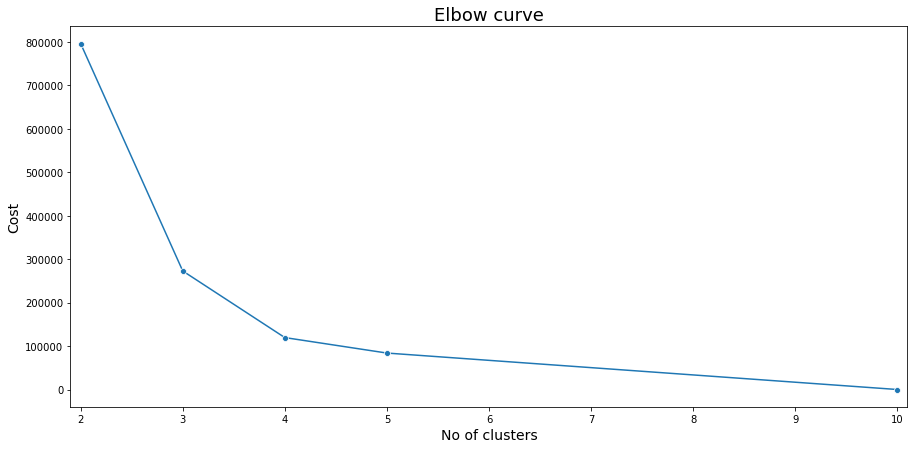

In [104]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import gower
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

## Features that will not be used for cluster analysis
exclude_columns   = {'id','name','categories','listings','address','latitude','longitude','Toy / Game Store'}
## Non Categorical Columns
non_categ_columns = {'id','name','categories','listings','address','latitude','longitude','Toy / Game Store','rating','ratingSignals','tips','photos'}
column_search     = list(set(formatted_df.columns.values) - exclude_columns)
categ_columns     = []
categ_indices     = []

## Dataset Used to Create Agglomerative Clustering
feature_df     = formatted_df[column_search]
feature_array  = np.asarray(feature_df)

## Gather All Categorical Feature Names
for i,col in enumerate(feature_df.columns.values):
    if col not in non_categ_columns:
        categ_columns.append(col)
        categ_indices.append(i)

def plot_elbow_matrix(df,exclude_columns=[]):
    categ_indices = []
    costs         = []
    k_nums        = [i for i in range(2,6)]
    for i,col in enumerate(df.columns.values):
        if col not in exclude_columns:
            categ_indices.append(i)
    for k in k_nums:
        model = KPrototypes(n_clusters=k,init="Huang")
        model.fit_predict(feature_df,categorical=categ_indices)
        costs.append(model.cost_)
    k_nums.append(10)
    costs.append(0)
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=k_nums,y=costs, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(2-0.1, 10+0.1))
    plt.plot()
    
#sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
plot_elbow_matrix(feature_df,non_categ_columns)

#### Optimal K and Agglomerative Clustering
As can be seen from the `elbow plot` the optimal K in this scenario would `k=5`. 

Since not all of the features are *categorical*, distances between data points will be
evaluated using the **gower distance** and stored into **distance matrix**.

From there, the hierarchy can be visualized using a **dendrogram** from the `scipy` library.

The same **distance matrix** can be used to fit and predict our ***Agglomerative Clustering Model***
using a `precomputed` affinity.

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 0, 0, 1, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])

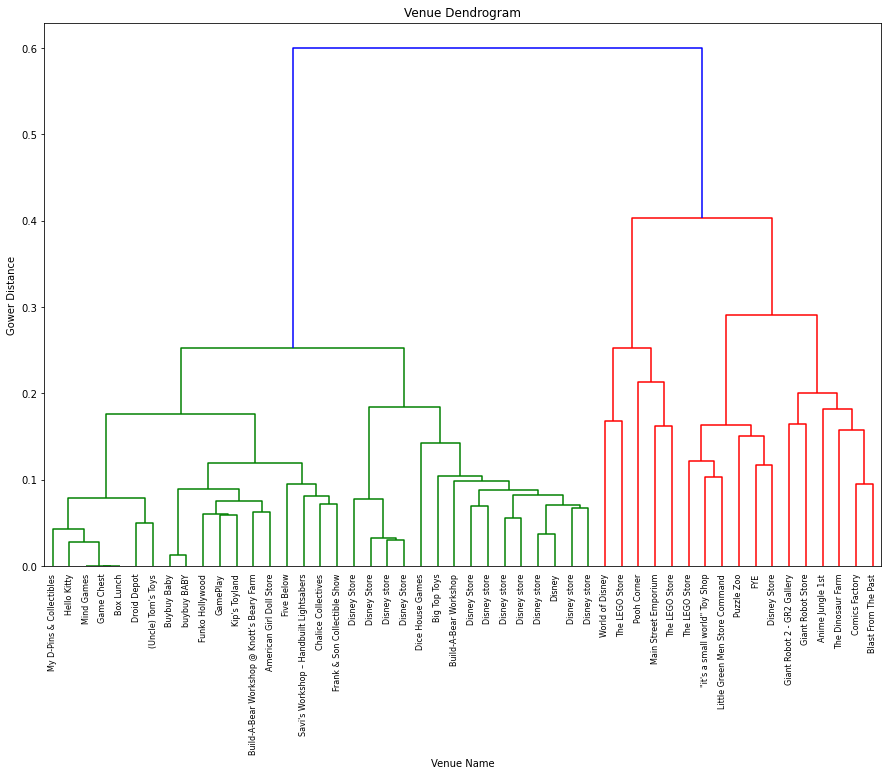

In [187]:
figure = plt.figure(figsize=(15,10))
ax     = figure.add_subplot(1,1,1)

ax.set_ylabel('Gower Distance')
ax.set_xlabel('Venue Name')
ax.set_title('Venue Dendrogram')
dist_matrix = gower.gower_matrix(np.asarray(feature_df))
sch.dendrogram(sch.linkage(dist_matrix,'complete'),orientation='top',labels=formatted_df['name'].values,distance_sort='descending',show_leaf_counts=True,ax=ax)

num_cluster   = 5

clustering    = AgglomerativeClustering(n_clusters=num_cluster,affinity="precomputed",linkage="complete")
agg_clusters  = clustering.fit_predict(dist_matrix)
agg_clusters

All that is left add the *corresponding cluster labels*
into our original dataset with the location names and coordinates.

In [113]:
copy_df            = formatted_df.copy()
#copy_df            = copy_df.reset_index()
cluster_df         = pd.DataFrame(agg_clusters)
cluster_df.columns = ['Cluster']

combined_df        = pd.concat([copy_df,cluster_df],axis=1).reset_index()
combined_df        = combined_df.drop(['categories','listings'],axis=1)
combined_df

,level_0,index,name,id,address,latitude,longitude,photos,parent-categories,verified,...,West Coast 2019,What should I do today? Oh I can go here!,dca,favorite places,my places,toys and games,لوس انجلس,マンガやアニメの画像 Best Manga & Anime Images,好きなお店,Cluster
0,0,0,Anime Jungle 1st,4b85b253f964a5207f6d31e3,319 E 2nd St Ste 103,34.049408,-118.240749,91.0,2.0,0,...,0,0,0,0,0,0,0,1,0,1
1,1,1,Box Lunch,5dec504dbed40a00072a3bbd,,34.035905,-118.083326,0.0,2.0,0,...,0,0,0,0,0,0,0,0,0,4
2,2,2,The Dinosaur Farm,4af33343f964a520b1eb21e3,1510 Mission St,34.115978,-118.151199,9.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4
3,3,3,Build-A-Bear Workshop @ Knott’s Beary Farm,5e3082776b6ff00007fd9429,8039 Beach Blvd,33.843169,-117.998639,0.0,2.0,0,...,0,0,0,0,0,0,0,0,0,4
4,4,4,Chalice Collectives,5d16e75b3e8ac40024229a1e,,34.134762,-118.050716,3.0,2.0,0,...,0,0,0,0,0,0,0,0,0,4
5,5,5,My D-Pins & Collectibles,57cf5325498e3025508b44c5,1648 W. Katella Ave. Suite B,33.802089,-117.939232,4.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4
6,6,6,Mind Games,5d1804bc4dcbca0023d181ec,,34.133780,-118.049045,1.0,2.0,0,...,0,0,0,0,0,0,0,0,0,4
7,7,7,Game Chest,5faf537db2e12c113624a98c,,34.135820,-118.052040,0.0,2.0,0,...,0,0,0,0,0,0,0,0,0,4
8,8,8,Hello Kitty,5c9ad42eff0306002c2c7ebd,,34.137822,-118.355035,7.0,4.0,0,...,0,0,0,0,0,0,0,0,0,4
9,9,9,Five Below,60373e244814104b3f3b2c7a,18309 Brookhurst St Ste 5,33.696298,-117.955702,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4


In [116]:
combined_df[['id','name','address','latitude','longitude','Cluster']]
combined_df['Cluster'].value_counts()

0    23
4    21
1     3
2     2
3     1
Name: Cluster, dtype: int64

#### Initiate Map Center
All that is left to do is initiate the center 
of our `folium` map.

This can be done by simply collecting and determining the **midpoint**
*latitude / longitude* of the original dataset.

In [118]:
midpoint_lat = ( combined_df['latitude'].max() + combined_df['latitude'].min() )/ 2.0
midpoint_lng = ( combined_df['longitude'].max() + combined_df['longitude'].min()) / 2.0

midpoint_lat,midpoint_lng

(33.94838954508498, -118.0876358)

In [119]:
def render_to_folium_map(df,center_lat,center_lng,num_clusters=3,cluster_label='Cluster',name_label='name'):
    map_clusters = folium.Map(location=[center_lat,center_lng],zoom_start=11)
    x = np.arange(num_clusters)
    ys = [i + x + (i*x)**2 for i in range(num_clusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    for lat,lng,name,cluster in zip(df['latitude'],df['longitude'],df[name_label],df[cluster_label]):
        label  = folium.Popup(name + '; Cluster: ' + str(cluster),parse_html=True)
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

map_clusters = render_to_folium_map(combined_df,midpoint_lat,midpoint_lng,5)
map_clusters 

## Results
As can be seen in the `folium` map, the venues belong to **Cluster 0,4**
are in more suburban areas and belong to franchises such as the **Disney Store or Box Lunch**

The more niche, hobby shops can be seen in **Cluster 3** in more downtown areas and include
popular spots like **Anime Jungle**. 

Interestingly, the *Disneyland / Downtown Disney* houses its own **2 clusters `[1,2]`** 
for its own more custom Disney Store and a store for Pooh Corner